Adapted from: https://www.pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/

Y: https://www.kaggle.com/code/vikashrajluhaniwal/building-visual-similarity-based-recommendation/notebook

Dataset: https://www.kaggle.com/datasets/vikashrajluhaniwal/fashion-images

# Aux functions

In [ ]:
# import the necessary packages
import os

# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

# import the necessary packages
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import random
import IPython

# import the necessary packages
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

from datetime import datetime
from PIL import Image, ImageOps

In [ ]:
# specify the shape of the inputs for our network
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
# specify the batch size and number of epochs
BATCH_SIZE = 32
EPOCHS = 100
EPOCHS_MLP = 50

# define the path to the base output directory
BASE_OUTPUT = ""
# use the base output path to derive the path to the serialized
# model along with training history plot
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

In [ ]:
def contrastive_loss(y, preds, margin=1):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)
	# calculate the contrastive loss between the true labels and
	# the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean((1 - y) * squaredPreds + y * squaredMargin)
	# return the computed contrastive loss to the calling function
	return loss

In [ ]:
def build_siamese_model(inputShape, embeddingDim=48):
	# specify the inputs for the feature extractor network
	inputs = Input(inputShape)
 
	# define the first set of CONV => RELU => POOL => DROPOUT layers
  # 64 filters 2x2
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs) # Si entrada 28x28x1 -> 28x28x64
	x = MaxPooling2D(pool_size=2)(x) # Si entrada 28x28x64 -> 14x14x64
	x = Dropout(0.3)(x)
 
	# second set of CONV => RELU => POOL => DROPOUT layers
  # 64 filters 2x2
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x) # Si entrada 14x14x64 -> 14x14x64
	x = MaxPooling2D(pool_size=2)(x) # Si entrada 14x14x64 -> 7x7x64
	x = Dropout(0.3)(x)
 
 	# prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim)(pooledOutput)
	# build the model
	model = Model(inputs, outputs)
	# return the model to the calling function
	return model

In [ ]:
def build_vgc19(inputShape, embeddingDim=48):
  base_model = VGG19(weights='imagenet', input_shape=inputShape, include_top=False, pooling=None)
  base_model.trainable = False

  inputs = Input(inputShape)
  x = base_model(inputs, training=False)

  # prepare the final outputs
  pooledOutput = GlobalAveragePooling2D()(x)
  outputs = Dense(embeddingDim)(pooledOutput)

  # build the model
  model = Model(inputs, outputs)

  # return the model to the calling function
  return model

In [ ]:
def build_IRNV2(inputShape, embeddingDim=48):
  base_model = InceptionResNetV2(weights='imagenet', input_shape=inputShape, include_top=False, pooling=None)
  base_model.trainable = False

  inputs = Input(inputShape)
  x = base_model(inputs, training=False)

  # prepare the final outputs
  pooledOutput = GlobalAveragePooling2D()(x)
  outputs = Dense(embeddingDim)(pooledOutput)

  # build the model
  model = Model(inputs, outputs)

  # return the model to the calling function
  return model

In [ ]:
def get_pairs_route(images_dir, data_df, image_shape):
	images = []
	labels = []
	names = []
	# we use de product type as different classes
	numClasses = data_df["ProductType"].unique()
 
	for i in os.listdir(images_dir):
		label = data_df[data_df["Image"]==i].ProductType.item()
		
		# load the image
		image = Image.open(images_dir+"/"+i)
	
		# All images should be same size
		image_resize = image.resize((image_shape[0], image_shape[0]))
		# convert image to numpy array
		if(image_shape[2] == 1):
			channel_img = image_resize.convert("L")
		elif(image_shape[2] == 3):
			channel_img = image_resize.convert("RGB")

		data = np.asarray(channel_img)
	
		images.append(data)
		labels.append(label)
		names.append(i)
	
	return np.stack(images), np.stack(labels), np.stack(names)
 

def make_pairs(images, labels):
	# initialize two empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative
	pairImages = []
	pairLabels = []
	# calculate the total number of classes present in the dataset
	# and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label

	classes = np.unique(labels)
 
	idx = [np.where(labels == i)[0] for i in classes]
	# loop over all images
	for idxA in range(len(images)):
		# grab the current image and label belonging to the current
		# iteration
		currentImage = images[idxA]
		label = labels[idxA]
		label_idx = np.where(classes == label)[0][0]
		# randomly pick an image that belongs to the *same* class
		# label
		idxB = np.random.choice(idx[label_idx])
		posImage = images[idxB]
		# prepare a positive pair and update the images and labels
		# lists, respectively
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])
		# grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *not* equal to the current label
		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]
		# prepare a negative pair of images and update our lists
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])
	# return a 2-tuple of our image pairs and labels
	return (np.array(pairImages), np.array(pairLabels))

In [ ]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [ ]:
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["f1_m"], label="train_f1")
	plt.plot(H.history["val_f1_m"], label="val_f1")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/F1")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def visualize_test(pairTrain_visualize, model_visualize, size=10, seed=42):
  np.random.seed(seed)
  sample_index = np.random.randint(pairTrain_visualize.shape[0], size=size)

  # loop over all image pairs
  for (i, (imageA, imageB)) in enumerate(pairTrain_visualize[sample_index]):
    # load both the images and convert them to grayscale
    # create a copy of both the images for visualization purpose
    origA = imageA.copy()
    origB = imageB.copy()

    if len(imageA.shape) == 3 and imageA.shape[-1] == 1:
      imageA = imageA[:, :, 0]
      imageB = imageB[:, :, 0]
    
    elif len(imageA.shape) == 4 and imageA.shape[-1] == 1:
      imageA = imageA[:, :, :, 0]
      imageB = imageB[:, :, :, 0]
    
    imageA = np.expand_dims(imageA, axis=0)
    imageB = np.expand_dims(imageB, axis=0)
    # use our siamese model to make predictions on the image pair,
    # indicating whether or not the images belong to the same class
    preds = model_visualize.predict([imageA, imageB])
    proba = preds[0][0]

    # initialize the figure
    fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
    if model_visualize.loss == "binary_crossentropy":
      plt.suptitle("Similarity: {:.2f}".format(proba))
    else:
      plt.suptitle("Distance: {:.2f}".format(proba))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(origA)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(origB)
    plt.axis("off")
    # show the plot
    plt.show()

In [ ]:
def get_recommendation(model, target, data, rec_number, printable=True):
  recommended_list = []

  origA = target.copy()
  target = np.expand_dims(target, axis=0)

  if len(origA.shape) == 3 and origA.shape[-1] == 1:
      origA = origA[:, :, 0]

  if len(origA.shape) == 4 and origA.shape[-1] == 1:
      origA = origA[:, :, :, 0]

  index = 0
  for img in data:
    # load both the images and convert them to grayscale
    # create a copy of both the images for visualization purpose
    
    origB = img.copy()

    if len(origB.shape) == 3 and origB.shape[-1] == 1:
      origB = origB[:, :, 0]

    if len(origB.shape) == 4 and origB.shape[-1] == 1:
      origB = origB[:, :, :, 0]
    
    
    img = np.expand_dims(img, axis=0)
    # use our siamese model to make predictions on the image pair,
    # indicating whether or not the images belong to the same class
    preds = model.predict([target, img], verbose = 0)
    proba = preds[0][0]

    recommended_list.append((origB, proba, index))
    index = index + 1
  
  # Queremos los mejores resultados
  if model.loss == "binary_crossentropy":
    # Better greater similarity
    recommended_list.sort(key=lambda a: a[1], reverse=True)
  else: 
    # Better less distance
    recommended_list.sort(key=lambda a: a[1])

  count = 0
  recommended_list_index = []
  for (rec_img, rec_pred, aux_index) in recommended_list:
    if count == rec_number:
      break
    # get the index of the recommended item in original list
    recommended_list_index.append(aux_index)

    if printable:
      # initialize the figure
      fig = plt.figure("Recommendations", figsize=(4, 2))
      if model.loss == "binary_crossentropy":
        plt.suptitle("Similarity: {:.2f}".format(rec_pred))
      else:
        plt.suptitle("Distance: {:.2f}".format(rec_pred))
      # show first image
      ax = fig.add_subplot(1, 2, 1)
      plt.imshow(origA)
      plt.axis("off")
      # show the second image
      ax = fig.add_subplot(1, 2, 2)
      plt.imshow(rec_img)
      plt.axis("off")
      # show the plot
      plt.show()
    count += 1

  return recommended_list_index

In [ ]:
def recall_and_precission_at_k(model, images, labels, k, p_groups=0.05):
  n_items = len(images)

  np.array(images)
  images = images / 255.0
  images = np.expand_dims(images, axis=-1)

  items_index = random.sample(range(1, n_items), int(n_items*p_groups))
  
  sum_recall_list = []
  sum_precission_list = []

  for index in items_index:
    # The data retrieved is not given to de the net
    target = images[index]
    target_label = labels[index]
    data = np.concatenate((images[:index], images[index+1:]), axis=0)
    data_labels = np.concatenate((labels[:index], labels[index+1:]), axis=0)

    # Get top recommendations
    top_index = get_recommendation(model, target, data, k, printable=False)
    top_labels = data_labels[top_index].tolist()

    # Compute Rel@k/Rel
    data_labels = data_labels.tolist()
    rel = data_labels.count(target_label)

    rel_at_k = top_labels.count(target_label)
    sum_recall_list.append(rel_at_k / rel)

    # Compute Rel@k/k
    sum_precission_list.append(rel_at_k / k)

  return sum(sum_recall_list) / len(sum_recall_list), sum(sum_precission_list) / len(sum_precission_list)

# Open the Data


## Load files

In [ ]:
!ls

fashion_short.zip  sample_data


In [ ]:
!unzip fashion_short.zip

Archive:  fashion_short.zip
   creating: fashion_short/data/
  inflating: fashion_short/data/fashion.csv  
   creating: fashion_short/data/Footwear/
   creating: fashion_short/data/Footwear/Men/
   creating: fashion_short/data/Footwear/Men/Images/
   creating: fashion_short/data/Footwear/Men/Images/images_with_product_ids/
  inflating: fashion_short/data/Footwear/Men/Images/images_with_product_ids/10037.jpg  
  inflating: fashion_short/data/Footwear/Men/Images/images_with_product_ids/10039.jpg  
  inflating: fashion_short/data/Footwear/Men/Images/images_with_product_ids/10097.jpg  
  inflating: fashion_short/data/Footwear/Men/Images/images_with_product_ids/10174.jpg  
  inflating: fashion_short/data/Footwear/Men/Images/images_with_product_ids/10180.jpg  
  inflating: fashion_short/data/Footwear/Men/Images/images_with_product_ids/10266.jpg  
  inflating: fashion_short/data/Footwear/Men/Images/images_with_product_ids/10267.jpg  
  inflating: fashion_short/data/Footwear/Men/Images/images_

In [ ]:
!mv fashion_short fashion

## Load DF

In [ ]:
fashion_df = pd.read_csv("fashion/data/fashion.csv")
fashion_df

,ProductId,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image,ImageURL
0,42419,Girls,Apparel,Topwear,Tops,White,Casual,Gini and Jony Girls Knit White Top,42419.jpg,http://assets.myntassets.com/v1/images/style/p...
1,34009,Girls,Apparel,Topwear,Tops,Black,Casual,Gini and Jony Girls Black Top,34009.jpg,http://assets.myntassets.com/v1/images/style/p...
2,40143,Girls,Apparel,Topwear,Tops,Blue,Casual,Gini and Jony Girls Pretty Blossom Blue Top,40143.jpg,http://assets.myntassets.com/v1/images/style/p...
3,23623,Girls,Apparel,Topwear,Tops,Pink,Casual,Doodle Kids Girls Pink I love Shopping Top,23623.jpg,http://assets.myntassets.com/v1/images/style/p...
4,47154,Girls,Apparel,Bottomwear,Capris,Black,Casual,Gini and Jony Girls Black Capris,47154.jpg,http://assets.myntassets.com/v1/images/style/p...
...,...,...,...,...,...,...,...,...,...,...
2901,51755,Women,Footwear,Shoes,Casual Shoes,Black,Casual,Catwalk Women Black Shoes,51755.jpg,http://assets.myntassets.com/v1/images/style/p...
2902,47630,Women,Footwear,Shoes,Flats,Blue,Casual,Carlton London Women Blue Shoes,47630.jpg,http://assets.myntassets.com/v1/images/style/p...
2903,32836,Women,Footwear,Shoes,Flats,Pink,Casual,Grendha Women Flori Pink Sandals,32836.jpg,http://assets.myntassets.com/v1/images/style/p...
2904,35821,Women,Footwear,Shoes,Heels,Black,Casual,Enroute Women Black Heels,35821.jpg,http://assets.myntassets.com/v1/images/style/p...


In [ ]:
print("Total number of products : ", fashion_df.shape[0])
print("Total number of unique subcategories : ", fashion_df["SubCategory"].nunique())
print("Total number of unique gender types : ", fashion_df["Gender"].nunique())

Total number of products :  2906
Total number of unique subcategories :  9
Total number of unique gender types :  4


In [ ]:
fashion_df["Gender"].value_counts()

Men      811
Women    769
Boys     759
Girls    567
Name: Gender, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


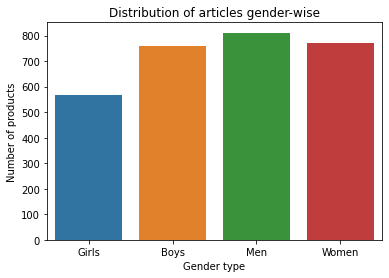

In [ ]:
plot = sns.countplot(fashion_df["Gender"])
plt.title("Distribution of articles gender-wise")
plt.xlabel("Gender type")
plt.ylabel("Number of products")
plot.set_xticklabels(plot.get_xticklabels())
plt.show()

In [ ]:
apparel_boys = fashion_df[fashion_df["Gender"]=="Boys"]
apparel_girls = fashion_df[fashion_df["Gender"]=="Girls"]
footwear_men = fashion_df[fashion_df["Gender"]=="Men"]
footwear_women = fashion_df[fashion_df["Gender"]=="Women"]

# Open Men Shoes Images

In [ ]:
train_data_dir = "fashion/data/Footwear/Men/Images/images_with_product_ids"

In [ ]:
men_footwear = fashion_df[fashion_df["Gender"]=="Men"][fashion_df["Category"]=="Footwear"]

<ipython-input-24-24f98cd4a642>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  men_footwear = fashion_df[fashion_df["Gender"]=="Men"][fashion_df["Category"]=="Footwear"]


In [ ]:
print("Total number of products : ", men_footwear.shape[0])
print("Total Subcategories for men footwear: ", men_footwear["SubCategory"].unique())
print("Total Product Types for men footwear: ", men_footwear["ProductType"].unique())
print("Total Colours for men footwear: ", men_footwear["Colour"].unique())

Total number of products :  811
Total Subcategories for men footwear:  ['Shoes' 'Flip Flops' 'Sandal']
Total Product Types for men footwear:  ['Casual Shoes' 'Flip Flops' 'Sandals' 'Formal Shoes' 'Sports Shoes'
 'Sports Sandals']
Total Colours for men footwear:  ['Black' 'White' 'Purple' 'Red' 'Khaki' 'Silver' 'Blue' 'Grey' 'Brown'
 'Beige' 'Tan' 'Olive' 'Navy Blue' 'Maroon' 'Yellow' 'Charcoal'
 'Turquoise Blue' 'Green' 'Orange' 'Multi' 'Mushroom Brown']


In [ ]:
images, labels, names = get_pairs_route(train_data_dir, men_footwear, IMG_SHAPE)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

In [ ]:
aux = 0
for i in X_train:
  assert i.shape == IMG_SHAPE, f"Shape expected {IMG_SHAPE} but {i.shape} was get. File n {aux}"
  aux+=1

In [ ]:
aux = 0
for i in images:
  assert i.shape == IMG_SHAPE, f"Shape expected {IMG_SHAPE} but {i.shape} was get. File n {aux}"
  aux+=1

# Siamese Mnist

## Data

In [ ]:
# load MNIST dataset and scale the pixel values to the range of [0, 1]
print("[INFO] loading MNIST dataset...")
(trainX, trainY), (testX, testY) = (np.array(X_train), np.array(y_train)), (np.array(X_test), np.array(y_test))
trainX = trainX / 255.0
testX = testX / 255.0
# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

In [ ]:
# configure the siamese network

# Why don't call build_siamese_model twice
# There are two sister networks, but implement them as a single instance

print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

[INFO] building siamese network...


## BCE

In [ ]:
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model_bce = Model(inputs=[imgA, imgB], outputs=outputs)

# Save best model epoch to disk
filepath = 'model_bce.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)


callbacks = [checkpoint, es]
# compile the model

"""
Binary cross-entropy because this is a two-class classification problem
More advanced loss functions can be used here as well:
  Triplet loss  
  Contrastive loss
"""
print("[INFO] compiling model...")
model_bce.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy", f1_m])
# train the model
print("[INFO] training model...")
history = model_bce.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS,
	callbacks=callbacks)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.5000 - f1_m: 0.6628
Epoch 1: val_loss improved from inf to 0.69347, saving model to model_bce.epoch01-loss0.69.hdf5
36/36 [==============================] - 17s 221ms/step - loss: 0.6936 - accuracy: 0.5000 - f1_m: 0.6628 - val_loss: 0.6935 - val_accuracy: 0.5000 - val_f1_m: 0.6667
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5000 - f1_m: 0.6620
Epoch 2: val_loss improved from 0.69347 to 0.69334, saving model to model_bce.epoch02-loss0.69.hdf5
36/36 [==============================] - 6s 174ms/step - loss: 0.6933 - accuracy: 0.5000 - f1_m: 0.6620 - val_loss: 0.6933 - val_accuracy: 0.4939 - val_f1_m: 0.6603
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5000 - f1_m: 0.6626
Epoch 3: val_loss did not improve from 0.69334
36/36 [==============================] - 6s 1

[INFO] plotting training history...


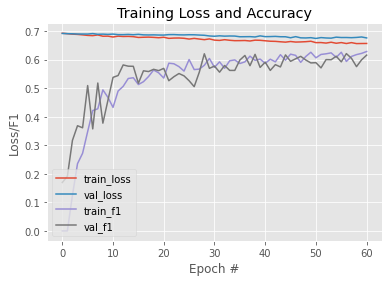

In [ ]:
# serialize the model to disk
# print("[INFO] saving siamese model...")
# model_bce.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

1/1 [==============================] - 0s 202ms/step


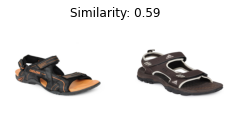

1/1 [==============================] - 0s 21ms/step


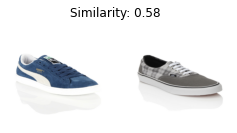

1/1 [==============================] - 0s 19ms/step


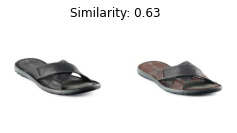

1/1 [==============================] - 0s 15ms/step


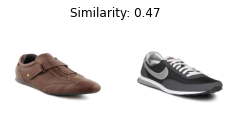

1/1 [==============================] - 0s 20ms/step


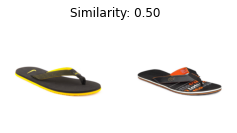

1/1 [==============================] - 0s 16ms/step


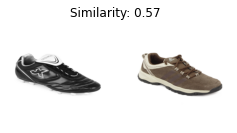

1/1 [==============================] - 0s 15ms/step


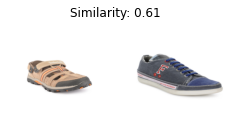

1/1 [==============================] - 0s 16ms/step


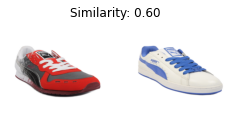

1/1 [==============================] - 0s 16ms/step


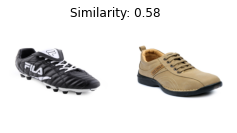

1/1 [==============================] - 0s 16ms/step


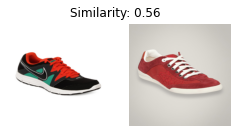

In [ ]:
visualize_test(pairTrain, model_bce)

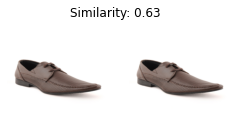

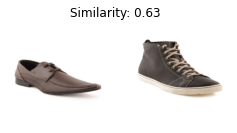

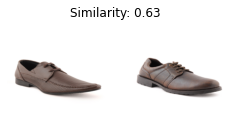

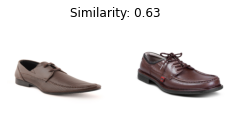

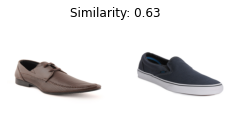

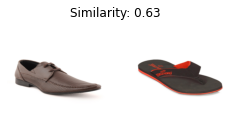

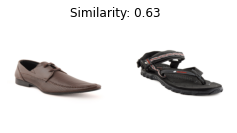

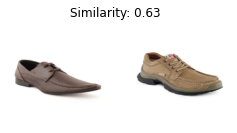

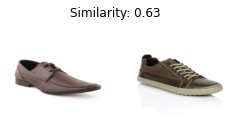

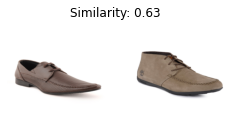

In [ ]:
get_recommendation(model_bce, trainX[0], trainX, 10)

In [ ]:
# Delete variables for RAM
del(trainX) 
del(trainY) 
del(testX) 
del(testY)
del(pairTrain)
del(labelTrain)
del(pairTest) 
del(labelTest)

In [ ]:
recall, precission = recall_and_precission_at_k(model_bce, images, labels, 10, p_groups=0.05)

In [ ]:
print(recall, precission)

0.011386246908963569 0.3025000000000001


## CL

In [ ]:
distance = Lambda(euclidean_distance)([featsA, featsB])
model_cl = Model(inputs=[imgA, imgB], outputs=distance)

# Save best model epoch to disk
filepath = 'model_cl.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks = [checkpoint, es]
# compile the model
# compile the model

"""
Binary cross-entropy because this is a two-class classification problem
More advanced loss functions can be used here as well:
  Triplet loss  
  Contrastive loss
"""
print("[INFO] compiling model...")
model_cl.compile(loss=contrastive_loss, optimizer="adam",
	metrics=["accuracy", f1_m])
# train the model
print("[INFO] training model...")
history = model_cl.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS,
	callbacks=callbacks)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.4894 - f1_m: 0.2078
Epoch 1: val_loss improved from inf to 0.36774, saving model to model_cl.epoch01-loss0.37.hdf5
36/36 [==============================] - 16s 217ms/step - loss: 0.3517 - accuracy: 0.4894 - f1_m: 0.2078 - val_loss: 0.3677 - val_accuracy: 0.5020 - val_f1_m: 0.1236
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 0.3276 - accuracy: 0.4938 - f1_m: 0.2386
Epoch 2: val_loss improved from 0.36774 to 0.34842, saving model to model_cl.epoch02-loss0.35.hdf5
36/36 [==============================] - 6s 174ms/step - loss: 0.3276 - accuracy: 0.4938 - f1_m: 0.2386 - val_loss: 0.3484 - val_accuracy: 0.5041 - val_f1_m: 0.1319
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.4841 - f1_m: 0.2741
Epoch 3: val_loss improved from 0.34842 to 0.34632, saving model to model_cl.epoch03-loss0.35.

[INFO] plotting training history...


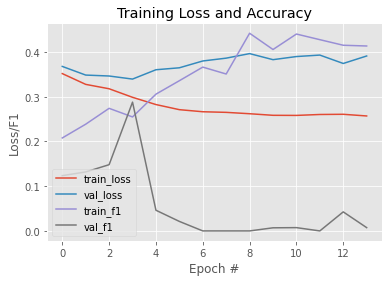

In [ ]:
# serialize the model to disk
# print("[INFO] saving siamese model...")
# model_bce.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

1/1 [==============================] - 0s 265ms/step


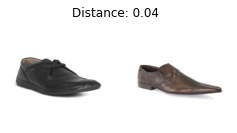

1/1 [==============================] - 0s 37ms/step


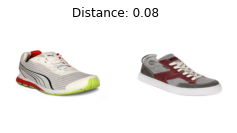

1/1 [==============================] - 0s 18ms/step


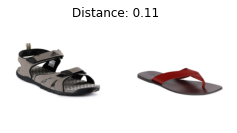

1/1 [==============================] - 0s 19ms/step


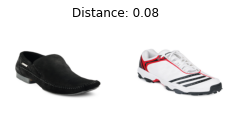

1/1 [==============================] - 0s 19ms/step


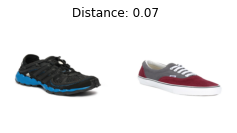

1/1 [==============================] - 0s 18ms/step


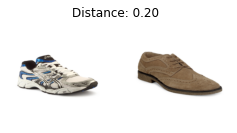

1/1 [==============================] - 0s 17ms/step


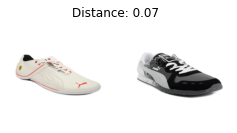

1/1 [==============================] - 0s 21ms/step


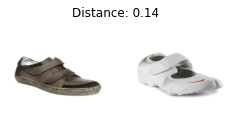

1/1 [==============================] - 0s 16ms/step


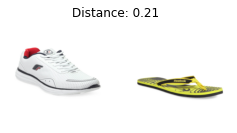

1/1 [==============================] - 0s 23ms/step


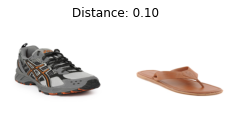

In [ ]:
visualize_test(pairTrain, model_cl)

In [ ]:
# Delete variables for RAM
del(trainX) 
del(trainY) 
del(testX) 
del(testY)
del(pairTrain)
del(labelTrain)
del(pairTest) 
del(labelTest)

In [ ]:
recall, precission = recall_and_precission_at_k(model_cl, images, labels, 10, p_groups=0.05)

In [ ]:
print(recall, precission)

0.024798287537297424 0.3849999999999999


# VGG19

## Data

In [ ]:
(trainX, trainY), (testX, testY) = (np.array(X_train), np.array(y_train)), (np.array(X_test), np.array(y_test))
trainX = trainX / 255.0
testX = testX / 255.0
# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

[INFO] preparing positive and negative pairs...


In [ ]:
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
# No podemos poner weights a "imagenet" porque las imagenes no tienen 3 canales
featureExtractor = build_vgc19(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

[INFO] building siamese network...


## BCE

In [ ]:
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model_vgg_bce = Model(inputs=[imgA, imgB], outputs=outputs)

# Save best model epoch to disk
filepath = 'model_vgg_bce.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks = [checkpoint, es]

"""
Binary cross-entropy because this is a two-class classification problem
More advanced loss functions can be used here as well:
  Triplet loss  
  Contrastive loss
"""
print("[INFO] compiling model...")
model_vgg_bce.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy", f1_m])
# train the model
print("[INFO] training model...")
history = model_vgg_bce.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS,
  callbacks=callbacks)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 0.7187 - accuracy: 0.5053 - f1_m: 0.0208
Epoch 1: val_loss improved from inf to 0.69233, saving model to model_vgg_bce.epoch01-loss0.69.hdf5
36/36 [==============================] - 34s 772ms/step - loss: 0.7187 - accuracy: 0.5053 - f1_m: 0.0208 - val_loss: 0.6923 - val_accuracy: 0.5123 - val_f1_m: 0.0618
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 0.6730 - accuracy: 0.5053 - f1_m: 0.0187
Epoch 2: val_loss improved from 0.69233 to 0.66987, saving model to model_vgg_bce.epoch02-loss0.67.hdf5
36/36 [==============================] - 19s 540ms/step - loss: 0.6730 - accuracy: 0.5053 - f1_m: 0.0187 - val_loss: 0.6699 - val_accuracy: 0.5123 - val_f1_m: 0.0618
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 0.6494 - accuracy: 0.5053 - f1_m: 0.0249
Epoch 3: val_loss improved from 0.66987 to 0.65621, saving model to model_vgg_bce.e

[INFO] plotting training history...


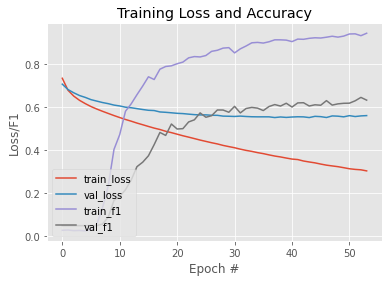

In [ ]:
# serialize the model to disk
# print("[INFO] saving siamese model...")
# model_bce.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

1/1 [==============================] - 2s 2s/step


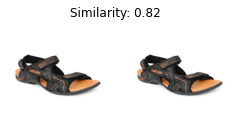

1/1 [==============================] - 0s 24ms/step


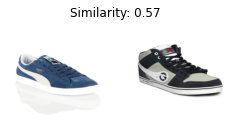

1/1 [==============================] - 0s 26ms/step


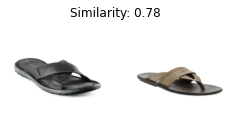

1/1 [==============================] - 0s 22ms/step


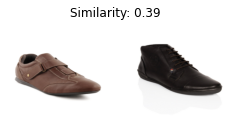

1/1 [==============================] - 0s 19ms/step


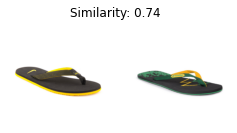

1/1 [==============================] - 0s 22ms/step


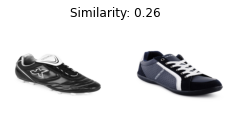

1/1 [==============================] - 0s 23ms/step


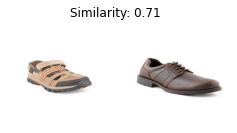

1/1 [==============================] - 0s 21ms/step


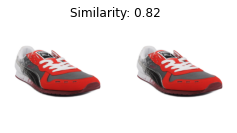

1/1 [==============================] - 0s 21ms/step


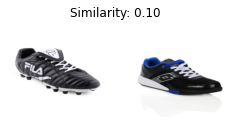

1/1 [==============================] - 0s 21ms/step


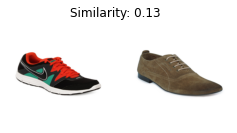

In [ ]:
visualize_test(pairTrain, model_vgg_bce)

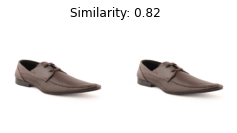

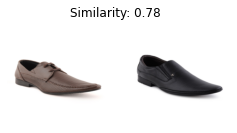

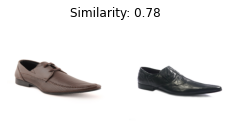

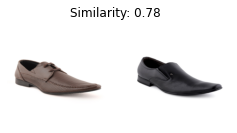

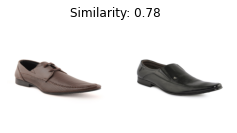

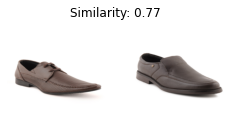

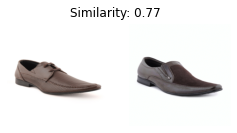

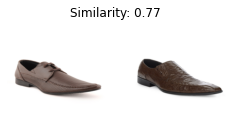

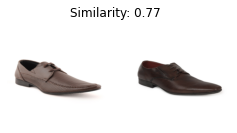

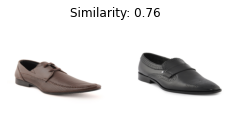

In [ ]:
get_recommendation(model_vgg_bce, trainX[0], trainX, 10)

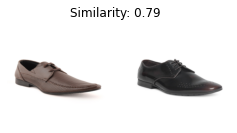

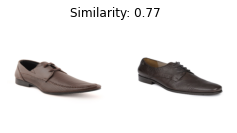

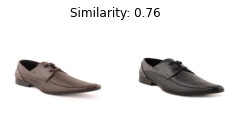

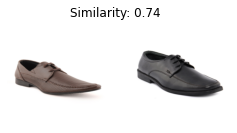

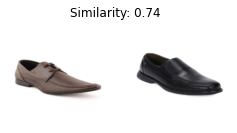

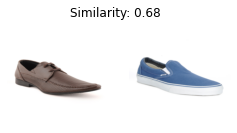

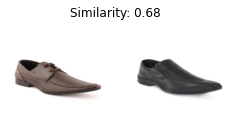

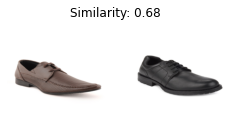

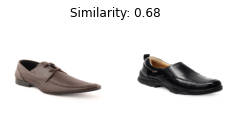

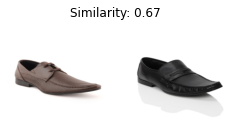

In [ ]:
get_recommendation(model_vgg_bce, trainX[0], testX, 10)

In [ ]:
# Delete variables for RAM
del(trainX) 
del(trainY) 
del(testX) 
del(testY)
del(pairTrain)
del(labelTrain)
del(pairTest) 
del(labelTest)

In [ ]:
recall, precission = recall_and_precission_at_k(model_vgg_bce, images, labels, 10, p_groups=0.05)

In [ ]:
print(recall, precission)

0.0550582564933191 0.8099999999999998


## CL

In [ ]:
distance = Lambda(euclidean_distance)([featsA, featsB])
model_vgg_cl = Model(inputs=[imgA, imgB], outputs=distance)

# Save best model epoch to disk
filepath = 'model_vgg_cl.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks = [checkpoint, es]
# compile the model

"""
Binary cross-entropy because this is a two-class classification problem
More advanced loss functions can be used here as well:
  Triplet loss  
  Contrastive loss
"""
print("[INFO] compiling model...")
model_vgg_cl.compile(loss=contrastive_loss, optimizer="adam",
	metrics=["accuracy", f1_m])
# train the model
print("[INFO] training model...")
history = model_vgg_cl.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS,
	callbacks=callbacks)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 0.2843 - accuracy: 0.4612 - f1_m: 0.5153
Epoch 1: val_loss improved from inf to 0.27289, saving model to model_vgg_cl.epoch01-loss0.27.hdf5
36/36 [==============================] - 23s 611ms/step - loss: 0.2843 - accuracy: 0.4612 - f1_m: 0.5153 - val_loss: 0.2729 - val_accuracy: 0.4775 - val_f1_m: 0.4801
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 0.2471 - accuracy: 0.5644 - f1_m: 0.5398
Epoch 2: val_loss did not improve from 0.27289
36/36 [==============================] - 20s 551ms/step - loss: 0.2471 - accuracy: 0.5644 - f1_m: 0.5398 - val_loss: 0.2738 - val_accuracy: 0.4754 - val_f1_m: 0.4944
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 0.2341 - accuracy: 0.6173 - f1_m: 0.6094
Epoch 3: val_loss did not improve from 0.27289
36/36 [==============================] - 19s 531ms/step - loss: 0.2341 - accuracy: 0.6173 - f1

[INFO] plotting training history...


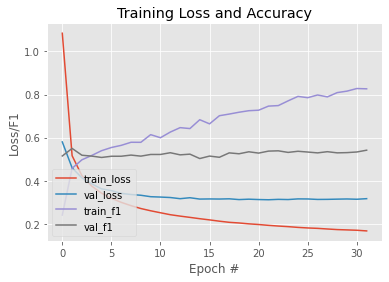

In [ ]:
# serialize the model to disk
# print("[INFO] saving siamese model...")
# model_bce.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

1/1 [==============================] - 0s 249ms/step


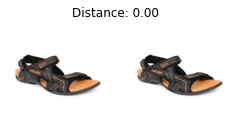

1/1 [==============================] - 0s 28ms/step


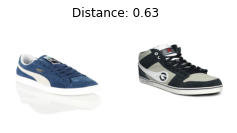

1/1 [==============================] - 0s 19ms/step


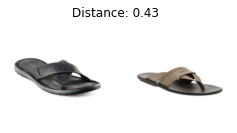

1/1 [==============================] - 0s 22ms/step


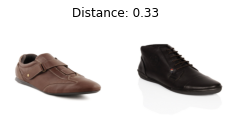

1/1 [==============================] - 0s 25ms/step


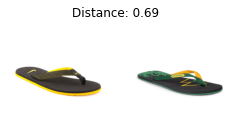

1/1 [==============================] - 0s 22ms/step


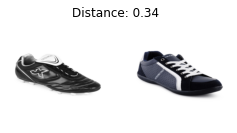

1/1 [==============================] - 0s 21ms/step


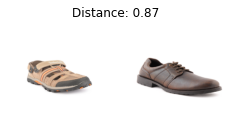

1/1 [==============================] - 0s 21ms/step


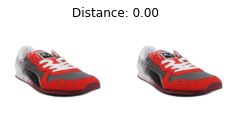

1/1 [==============================] - 0s 23ms/step


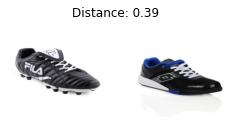

1/1 [==============================] - 0s 28ms/step


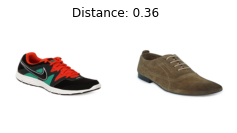

In [ ]:
visualize_test(pairTrain, model_vgg_cl)

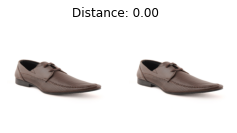

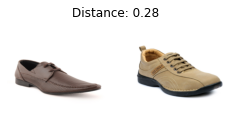

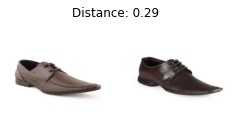

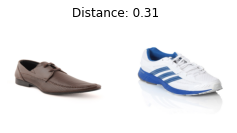

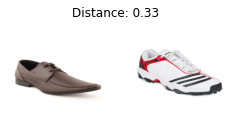

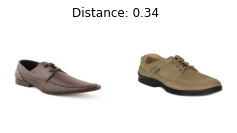

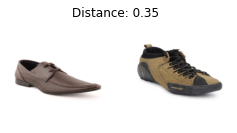

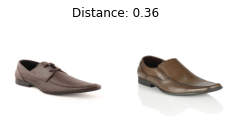

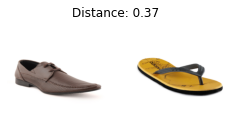

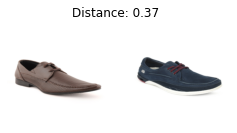

In [ ]:
get_recommendation(model_vgg_cl, trainX[0], trainX, 10)

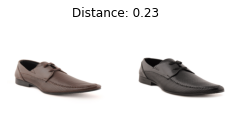

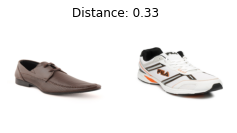

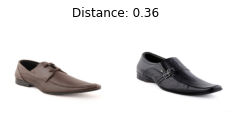

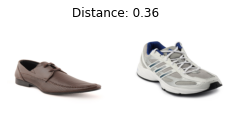

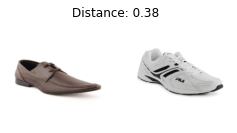

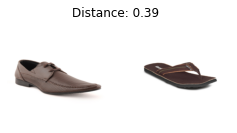

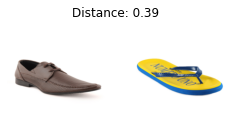

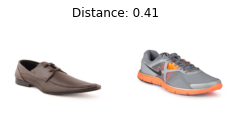

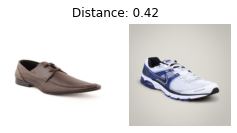

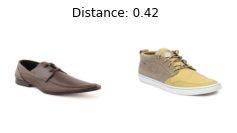

In [ ]:
get_recommendation(model_vgg_cl, trainX[0], testX, 10)

In [ ]:
# Delete variables for RAM
del(trainX) 
del(trainY) 
del(testX) 
del(testY)
del(pairTrain)
del(labelTrain)
del(pairTest) 
del(labelTest)

In [ ]:
recall, precission = recall_and_precission_at_k(model_vgg_cl, images, labels, 10, p_groups=0.05)

In [ ]:
print(recall, precission) 

0.019962943635838323 0.2925


# InceptionResnetV2

## Data

In [ ]:
(trainX, trainY), (testX, testY) = (np.array(X_train), np.array(y_train)), (np.array(X_test), np.array(y_test))
trainX = trainX / 255.0
testX = testX / 255.0
# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

[INFO] preparing positive and negative pairs...


In [ ]:
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
# No podemos poner weights a "imagenet" porque las imagenes no tienen 3 canales
featureExtractor = build_IRNV2(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

[INFO] building siamese network...


## BCE

In [ ]:
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model_irnv2_bce = Model(inputs=[imgA, imgB], outputs=outputs)

# Save best model epoch to disk
filepath = 'model_irnv2_bce.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks = [checkpoint, es]

"""
Binary cross-entropy because this is a two-class classification problem
More advanced loss functions can be used here as well:
  Triplet loss  
  Contrastive loss
"""
print("[INFO] compiling model...")
model_irnv2_bce.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy", f1_m])
# train the model
print("[INFO] training model...")
history = model_irnv2_bce.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS,
  callbacks=callbacks)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 1.1383 - accuracy: 0.4929 - f1_m: 0.6551
Epoch 1: val_loss improved from inf to 1.00491, saving model to model_irnv2_bce.epoch01-loss1.00.hdf5
36/36 [==============================] - 55s 806ms/step - loss: 1.1383 - accuracy: 0.4929 - f1_m: 0.6551 - val_loss: 1.0049 - val_accuracy: 0.4857 - val_f1_m: 0.6542
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 0.8628 - accuracy: 0.4929 - f1_m: 0.6557
Epoch 2: val_loss improved from 1.00491 to 0.91382, saving model to model_irnv2_bce.epoch02-loss0.91.hdf5
36/36 [==============================] - 20s 571ms/step - loss: 0.8628 - accuracy: 0.4929 - f1_m: 0.6557 - val_loss: 0.9138 - val_accuracy: 0.4857 - val_f1_m: 0.6542
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 0.8000 - accuracy: 0.4929 - f1_m: 0.6595
Epoch 3: val_loss improved from 0.91382 to 0.87787, saving model to model_irnv2

[INFO] plotting training history...


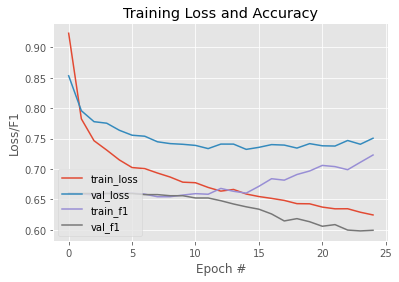

In [ ]:
# serialize the model to disk
# print("[INFO] saving siamese model...")
# model_bce.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

1/1 [==============================] - 6s 6s/step


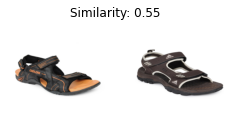

1/1 [==============================] - 0s 51ms/step


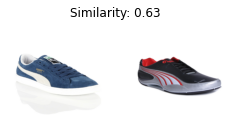

1/1 [==============================] - 0s 68ms/step


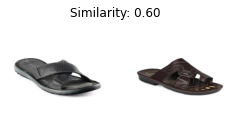

1/1 [==============================] - 0s 50ms/step


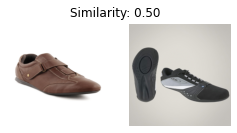

1/1 [==============================] - 0s 57ms/step


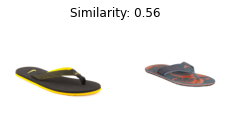

1/1 [==============================] - 0s 62ms/step


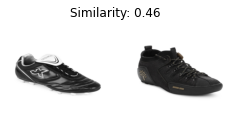

1/1 [==============================] - 0s 58ms/step


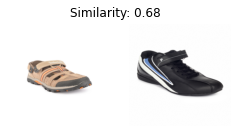

1/1 [==============================] - 0s 53ms/step


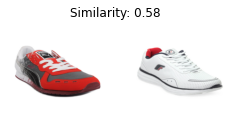

1/1 [==============================] - 0s 52ms/step


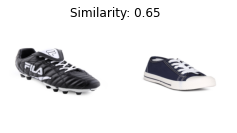

1/1 [==============================] - 0s 55ms/step


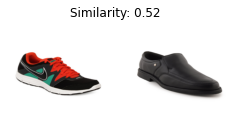

In [ ]:
visualize_test(pairTrain, model_irnv2_bce)

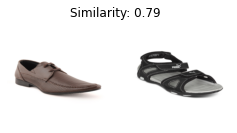

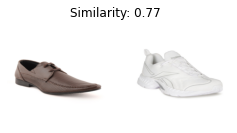

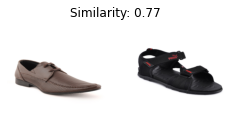

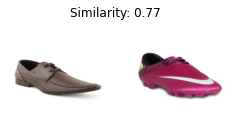

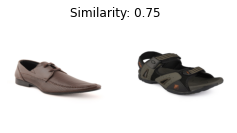

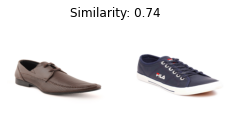

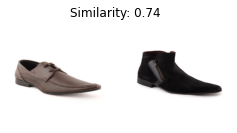

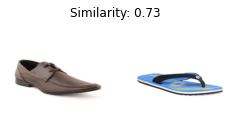

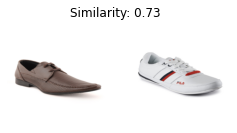

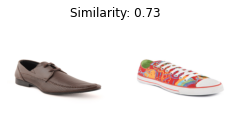

In [ ]:
get_recommendation(model_irnv2_bce, trainX[0], trainX, 10)

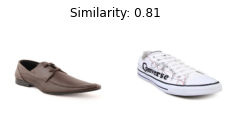

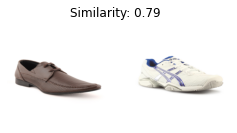

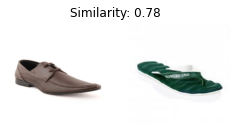

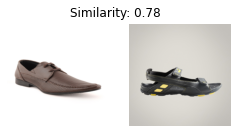

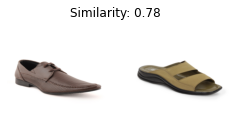

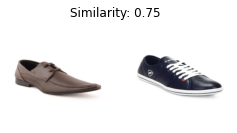

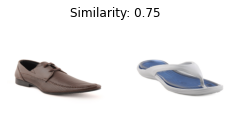

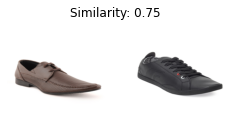

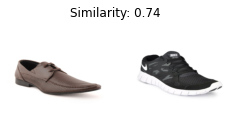

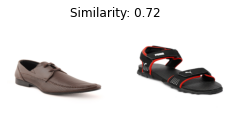

In [ ]:
get_recommendation(model_irnv2_bce, trainX[0], testX, 10)

In [ ]:
# Delete variables for RAM
del(trainX) 
del(trainY) 
del(testX) 
del(testY)
del(pairTrain)
del(labelTrain)
del(pairTest) 
del(labelTest)

In [ ]:
recall, precission = recall_and_precission_at_k(model_irnv2_bce, images, labels, 10, p_groups=0.05)

In [ ]:
print(recall, precission) 

0.011421155157004504 0.1725


## CL

In [ ]:
distance = Lambda(euclidean_distance)([featsA, featsB])
model_irnv2_cl = Model(inputs=[imgA, imgB], outputs=distance)

# Save best model epoch to disk
filepath = 'model_irnv2_cl.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks = [checkpoint, es]
# compile the model

"""
Binary cross-entropy because this is a two-class classification problem
More advanced loss functions can be used here as well:
  Triplet loss  
  Contrastive loss
"""
print("[INFO] compiling model...")
model_irnv2_cl.compile(loss=contrastive_loss, optimizer="adam",
	metrics=["accuracy", f1_m])
# train the model
print("[INFO] training model...")
history = model_irnv2_cl.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS,
	callbacks=callbacks)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 4.0617 - accuracy: 0.4929 - f1_m: 0.6573
Epoch 1: val_loss improved from inf to 2.27868, saving model to model_irnv2_cl.epoch01-loss2.28.hdf5
36/36 [==============================] - 46s 759ms/step - loss: 4.0617 - accuracy: 0.4929 - f1_m: 0.6573 - val_loss: 2.2787 - val_accuracy: 0.4918 - val_f1_m: 0.6596
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 1.2143 - accuracy: 0.4929 - f1_m: 0.6482
Epoch 2: val_loss improved from 2.27868 to 1.59778, saving model to model_irnv2_cl.epoch02-loss1.60.hdf5
36/36 [==============================] - 20s 559ms/step - loss: 1.2143 - accuracy: 0.4929 - f1_m: 0.6482 - val_loss: 1.5978 - val_accuracy: 0.4918 - val_f1_m: 0.6596
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 0.7973 - accuracy: 0.4912 - f1_m: 0.6516
Epoch 3: val_loss improved from 1.59778 to 1.36196, saving model to model_irnv2_c

1/1 [==============================] - 5s 5s/step


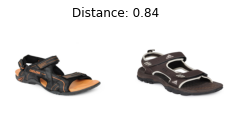

1/1 [==============================] - 0s 54ms/step


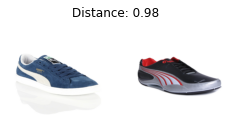

1/1 [==============================] - 0s 52ms/step


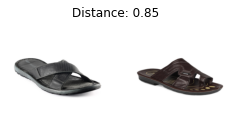

1/1 [==============================] - 0s 54ms/step


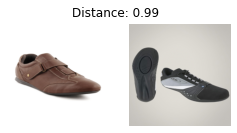

1/1 [==============================] - 0s 84ms/step


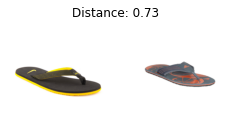

1/1 [==============================] - 0s 51ms/step


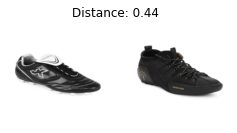

1/1 [==============================] - 0s 59ms/step


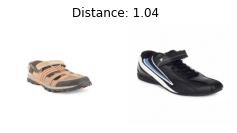

1/1 [==============================] - 0s 50ms/step


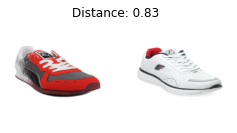

1/1 [==============================] - 0s 50ms/step


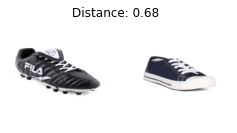

1/1 [==============================] - 0s 65ms/step


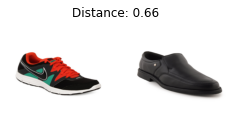

In [ ]:
visualize_test(pairTrain, model_irnv2_cl)

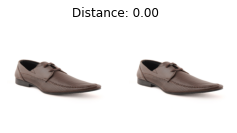

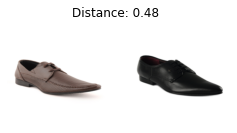

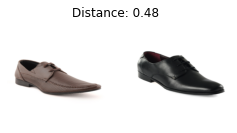

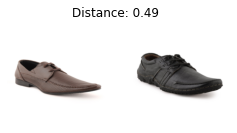

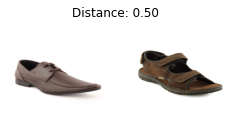

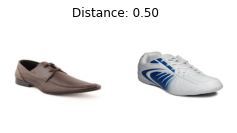

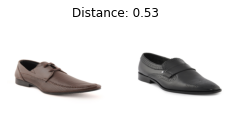

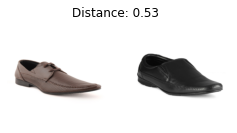

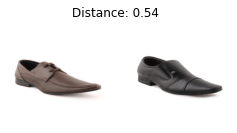

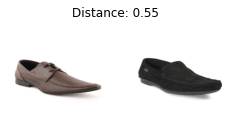

In [ ]:
get_recommendation(model_irnv2_cl, trainX[0], trainX, 10)

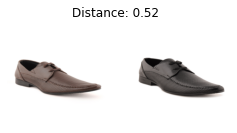

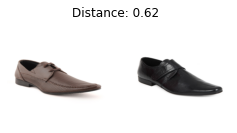

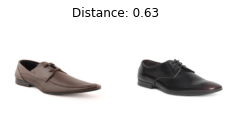

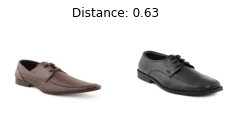

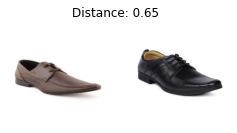

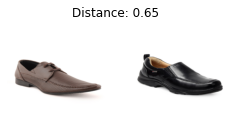

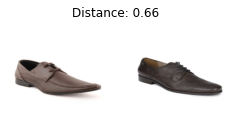

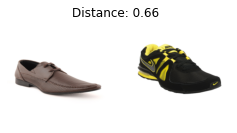

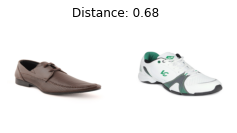

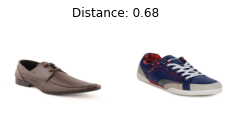

In [ ]:
get_recommendation(model_irnv2_cl, trainX[0], testX, 10)

In [ ]:
# Delete variables for RAM
del(trainX) 
del(trainY) 
del(testX) 
del(testY)
del(pairTrain)
del(labelTrain)
del(pairTest) 
del(labelTest)

In [ ]:
recall, precission = recall_and_precission_at_k(model_irnv2_cl, images, labels, 10, p_groups=0.05)

In [ ]:
print(recall, precission) 

0.023601773440440368 0.4049999999999999
